Import neccessary packages

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"manjindersinghpadda","key":"b2101be7b269b24a7eed1d9963964e82"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 75 Apr 20 23:00 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle 

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip plantdisease.zip

Archive:  plantdisease.zip
replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/plantvillage'
width=256
height=256
depth=3

Function to convert images to array

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [ ]:
import os

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = os.listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_folder_path = os.path.join(directory_root, plant_folder)
        if os.path.isdir(plant_folder_path):
            plant_disease_folder_list = os.listdir(plant_folder_path)

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"[INFO] Loading images: {plant_disease_folder} ...")
                plant_disease_folder_path = os.path.join(plant_folder_path, plant_disease_folder)
                if os.path.isdir(plant_disease_folder_path):
                    print(f"[INFO] Processing {plant_disease_folder} ...")
                    plant_disease_image_list = os.listdir(plant_disease_folder_path)
                        
                    for single_plant_disease_image in plant_disease_image_list :
                        if single_plant_disease_image == ".DS_Store" :
                            plant_disease_image_list.remove(single_plant_disease_image)

                    for image in plant_disease_image_list[:200]:
                        image_directory = os.path.join(plant_disease_folder_path, image)
                        if image_directory.endswith(".jpg") or image_directory.endswith(".JPG"):
                            image_list.append(convert_image_to_array(image_directory))
                            label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Loading images: Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Loading images: Potato___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Loading images: Tomato_healthy ...
[INFO] Processing Tomato_healthy ...
[INFO] Loading images: Potato___Early_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Loading images: Potato___Late_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Loading images: Tomato_Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Loading images: Tomato_Early_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Loading images: Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Loading images: Pepper__bell___healthy ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Loading images: Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Loading images: Tom

Get Size of Processed Image

In [ ]:
image_size = len(image_list)

In [ ]:
image_size

2951

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-27-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
73/73 [==============================] - 54s 587ms/step - loss: 0.6170 - accuracy: 0.2199 - val_loss: 0.6246 - val_accuracy: 0.0711
Epoch 2/25
73/73 [==============================] - 39s 526ms/step - loss: 0.2858 - accuracy: 0.2964 - val_loss: 0.3972 - val_accuracy: 0.0745
Epoch 3/25
73/73 [==============================] - 40s 550ms/step - loss: 0.1873 - accuracy: 0.5168 - val_loss: 1.4880 - val_accuracy: 0.0711
Epoch 4/25
73/73 [==============================] - 45s 614ms/step - loss: 0.1503 - accuracy: 0.6074 - val_loss: 3.6734 - val_accuracy: 0.0711
Epoch 5/25
73/73 [==============================] - 40s 543ms/step - loss: 0.1305 - accuracy: 0.6572 - val_loss: 0.8653 - val_accuracy: 0.0998
Epoch 6/25
73/73 [==============================] - 39s 530ms/step - loss: 0.1171 - accuracy: 0.6997 - val_loss: 1.2681 - val_accuracy: 0.0964
Epoch 7/25
73/73 [==============================] - 39s 524ms/step - loss: 0.1121 - accuracy: 0.7182 - val_loss: 2.2837 - val_accuracy: 0.1404

Plot the train and val curve

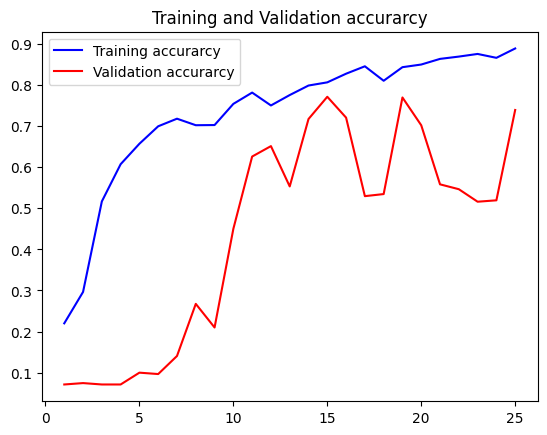

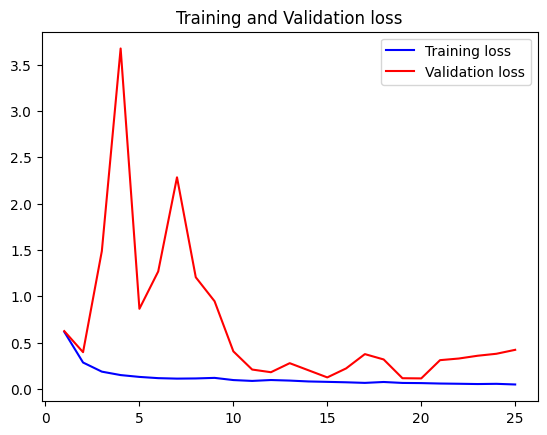

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 36ms/step - loss: 0.4226 - accuracy: 0.7394
Test Accuracy: 73.94247055053711


Save model using Pickle

In [ ]:
print("[INFO] Saving model...")
#file_name='cnn_model.pkl'
pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save('C:\\Users\\en0216\\Downloads\\cnn_model.pkl')
print("saved")

[INFO] Saving model...


saved


In [ ]:
image_dir="/content/PlantVillage/Potato___Early_blight/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG"
#image_dir="C:\\Users\\SHARATHVEER REDDY K\\Desktop\archive\\PlantVillage\\PlantVillage\\plant_folder\\Potato___Early_blight"

im=convert_image_to_array(image_dir)
#print(im)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
result=model.predict(npp_image)

print(result)

1/1 [==============================] - 1s 808ms/step
[[2.45745896e-10 1.19988139e-13 9.99989748e-01 1.00895923e-05
  1.04400236e-07 9.26742594e-09 3.35180234e-12 3.14643245e-09
  6.45471324e-18 2.41527336e-11 6.85825216e-11 3.98020999e-13
  1.96255494e-11 8.41335855e-12 1.17772512e-08]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.99998975
Potato___Early_blight
